In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy as np
import scipy
import glob
import sys
from scipy import io
import cv2
import math
import random
import keras
from sklearn import preprocessing

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
POET_DIR = "D:/data/POETdataset/"
PATCHES_FILE = os.path.join(POET_DIR, "all_patches_list.npy")
LABELS_FILE = os.path.join(POET_DIR, "all_labels_list.npy")
pascal_images = os.path.join(POET_DIR, 'PascalImages')
CLASS2IDX_FILE = os.path.join(POET_DIR, 'class2idx.npy')
IDX2CLASS_FILE = os.path.join(POET_DIR, 'idx2class.npy')
PATCH_SIZE = 32
HALF_PATCH = PATCH_SIZE//2
DATASET_SIZE = 6270
VALIDATION_PERC = 0.2
MAX_GAZE_POINTS = 3 # TEMPORARY
MIN_GAZE_POINTS = 3
VGG_NR_FEATURES = 512
user_index = 0 # TEMPORARY
BATCH_SIZE = 50
os.chdir(POET_DIR)

In [3]:
%pwd

'D:\\data\\POETdataset'

# LOAD DATA

In [18]:
x = np.load(PATCHES_FILE)

In [19]:
y = np.load(LABELS_FILE)

In [20]:
class2idx = np.load(CLASS2IDX_FILE).tolist()

In [21]:
idx2class = np.load(IDX2CLASS_FILE).tolist()

## CHECKING DATA

In [22]:
len(x)

4173

In [23]:
len(y)

4173

In [24]:
x[0].shape

(3, 32, 32, 3)

In [25]:
x[:,:].min(), x[:,:].max()

(0, 255)

In [26]:
idx2class[3]

'cat'

In [27]:
class2idx['cat']

3

# DATA EXPLORATION

## IMBALANCED DATASET

(array([368., 302., 325., 693., 215., 404., 879., 333., 279., 375.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

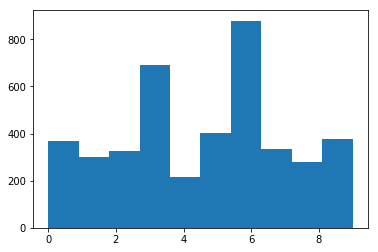

In [28]:
plt.hist(y,bins=len(idx2class))

# Extract features for patches

Now using the preprocessing function!!!!!!!!!

In [29]:
learned_model = keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='max')
pp_func = keras.applications.resnet50.preprocess_input

features_extractor_model = keras.models.Sequential()
features_extractor_model.add(keras.layers.Lambda(pp_func,name='preprocessing',input_shape=(PATCH_SIZE,PATCH_SIZE,3)))
features_extractor_model.add(learned_model)

In [16]:
x = x.reshape((4173*3,32,32,3))
xtrain = features_extractor_model.predict(x)

In [30]:
xtrain.shape

(12519, 2048)

In [31]:
xtrain = xtrain.reshape((4173,3,xtrain.shape[1]))

In [32]:
xtrain.shape

(4173, 3, 2048)

## ONE HOT ENCODER

In [33]:
ytrain = y

In [34]:
from sklearn.preprocessing import OneHotEncoder


In [35]:
enc = OneHotEncoder(handle_unknown='ignore')

In [36]:
ytrain = ytrain.reshape((-1,1))

In [37]:
enc.fit(ytrain)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [38]:
ytrain = enc.transform(ytrain)

In [39]:
ytrain[22].argmax()

0

In [40]:
ytrain.shape, xtrain.shape

((4173, 10), (4173, 3, 2048))

# MODEL TRAINING

In [56]:
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain.todense(), test_size=0.1, stratify=ytrain.todense())

## MODEL DEFINITION

In [54]:
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(128, dropout=0.2, input_shape=(MAX_GAZE_POINTS, xtrain.shape[2],)))
    model.add(keras.layers.Dense(len(idx2class), activation='sigmoid'))


    model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.rmsprop(lr=0.00005),
                metrics=['accuracy'])
    print(model.summary())
    return model

In [55]:
filepath="weights-imbalanced-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [59]:
model = get_model()
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    verbose=1,
#     batch_size=64,
    epochs=50,
    callbacks=[checkpoint]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               1114624   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 1,115,914
Trainable params: 1,115,914
Non-trainable params: 0
_________________________________________________________________
None
Train on 3755 samples, validate on 418 samples
Epoch 1/50
3755/3755 [==============================] - 4s 1ms/step - loss: 2.2066 - acc: 0.1973 - val_loss: 2.0761 - val_acc: 0.2608

Epoch 00001: val_acc improved from -inf to 0.26077, saving model to weights-imbalanced-01-0.26.hdf5
Epoch 2/50
3755/3755 [==============================] - 2s 434us/step - loss: 2.0548 - acc: 0.2591 - val_loss: 1.9417 - val_acc: 0.2895

Epoch 00002: val_acc improved from 0.26077 to 0.28947, saving model to weights-imbalanced-02-0.29.hdf5
E

## BALANCED CLASSES

In [ ]:
from scipy import stats

In [ ]:
freq = stats.itemfreq(y)
freq

In [ ]:
MIN_CLASS = np.min(freq, axis=0)[1]

MIN_CLASS

In [ ]:
xtrain_bal = np.zeros((MIN_CLASS*10, MAX_GAZE_POINTS, VGG_NR_FEATURES))
ytrain_bal = np.zeros((MIN_CLASS*10))
counts = {k:0 for k in idx2class.keys()}

In [ ]:
global_counter = 0
for i, ins in enumerate(xtrain):
    class_of_ins = y[i]
    if counts[class_of_ins] < MIN_CLASS:
        xtrain_bal[global_counter] = ins
        ytrain_bal[global_counter] = class_of_ins
        counts[class_of_ins] += 1
        global_counter += 1


In [ ]:
stats.itemfreq(ytrain_bal)

## MODEL

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
ytrain_bal = ytrain_bal.reshape((-1,1))

In [ ]:
enc.fit(ytrain_bal)

In [ ]:
ytrain_bal = enc.transform(ytrain_bal)

In [ ]:
ytrain_bal[22].argmax()

In [ ]:
def get_model():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, dropout=0.2, input_shape=(MAX_GAZE_POINTS, VGG_NR_FEATURES)))
    model.add(keras.layers.Dense(len(idx2class), activation='sigmoid'))

    optm = keras.optimizers.rmsprop(lr=0.00001, )
    model.compile(loss='categorical_crossentropy',
                optimizer=optm,
                metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
filepath="bal_weights_rms-64layers-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
model = get_model()
model.fit(
  xtrain_bal,
  ytrain_bal,
  validation_split=VALIDATION_PERC,
  verbose=2,
  epochs=50,
  callbacks=[checkpoint]
)